In [1]:
%load_ext autoreload
%autoreload 2

In [92]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import defaultdict

PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [3]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,1,1,1], 
                      mode='full_window', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
                    #   mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')

da.load_results_da()
center_idx_ctxt = da.queries[-1].get_center_idx()
winsize_ctxt = da.queries[-1].winsize
if center_idx_ctxt < 0:
    center_idx_ctxt = winsize_ctxt + center_idx_ctxt
da.seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658


In [149]:
def get_phi_psi_dist(q, seq_ctxt):
    seq = q.get_subseq(seq_ctxt)
    phi_psi_dist = q.results_window[q.results_window.seq == seq]
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]
    return phi_psi_dist

def get_xrays(da, q, seq_ctxt):
    center_idx = q.get_center_idx_pos()
    xray_pos = da.xray_phi_psi[da.xray_phi_psi.seq_ctxt == seq_ctxt].pos.iloc[0]
    xrays = da.xray_phi_psi[(da.xray_phi_psi.pos >= xray_pos-center_idx) & (da.xray_phi_psi.pos < xray_pos-center_idx+q.winsize)]
    xray_point = np.concatenate([xrays['phi'].values, xrays['psi'].values])
    return xrays, xray_point

def xray_sil_score(phi_psi_dist, xray_point):
    cluster_aves = phi_psi_dist.groupby('cluster').mean()
    nearest_cluster_idx = np.linalg.norm(diff(cluster_aves.values, xray_point), axis=1).argmin()
    nearest_cluster = cluster_aves.iloc[nearest_cluster_idx].name
    
    xray_sil = silhouette_samples(
        np.vstack([phi_psi_dist.iloc[:,:-1], xray_point[np.newaxis,:]]), 
        np.append(phi_psi_dist.cluster.values, nearest_cluster)
    )[-1]
    return xray_sil

def assign_clusters(phi_psi_dist, eps=75):
    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)
    precomputed_dists = np.linalg.norm(diff(phi_psi_dist.values[:,np.newaxis], phi_psi_dist.values), axis=2)
    phi_psi_dist['cluster'] = DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(precomputed_dists).labels_
    n_clusters = len(phi_psi_dist.cluster.unique())
    return n_clusters

In [ ]:
results = []
q = da.queries[0]
for seq_ctxt in da.seqs_for_window:
    phi_psi_dist = get_phi_psi_dist(q, seq_ctxt)
    xrays, xray_point = get_xrays(da, q, seq_ctxt)
    if phi_psi_dist.shape[0] == 0:
        continue
    if xrays.shape[0] != q.winsize:
        continue
    n_clusters = assign_clusters(phi_psi_dist)
    phi_psi_dist = phi_psi_dist[phi_psi_dist.cluster != -1]

    sil_score = silhouette_score(phi_psi_dist.iloc[:,:-1], phi_psi_dist.cluster)
    xray_sil = xray_sil_score(phi_psi_dist, xray_point)

    n_samples = phi_psi_dist.shape[0]
    results.append([da.casp_protein_id, seq_ctxt, n_samples, n_clusters, sil_score, xray_sil])
    results_df = pd.DataFrame(results, columns=['protein', 'seq_ctxt', 'n_samples', 'n_clusters', 'sil_score', 'xray_sil'])
    results_df.to_csv('8d_cluster_results.csv', index=False)

21 cluster
 1     1784
 0      159
-1      159
 8       80
 11      38
 7       35
 12      26
 9       22
 10      20
 19      20
 5       14
 6       12
 2        8
 15       8
 16       8
 14       6
 3        6
 18       6
 13       6
 4        5
 17       5
Name: count, dtype: int64
0.04877804153453307


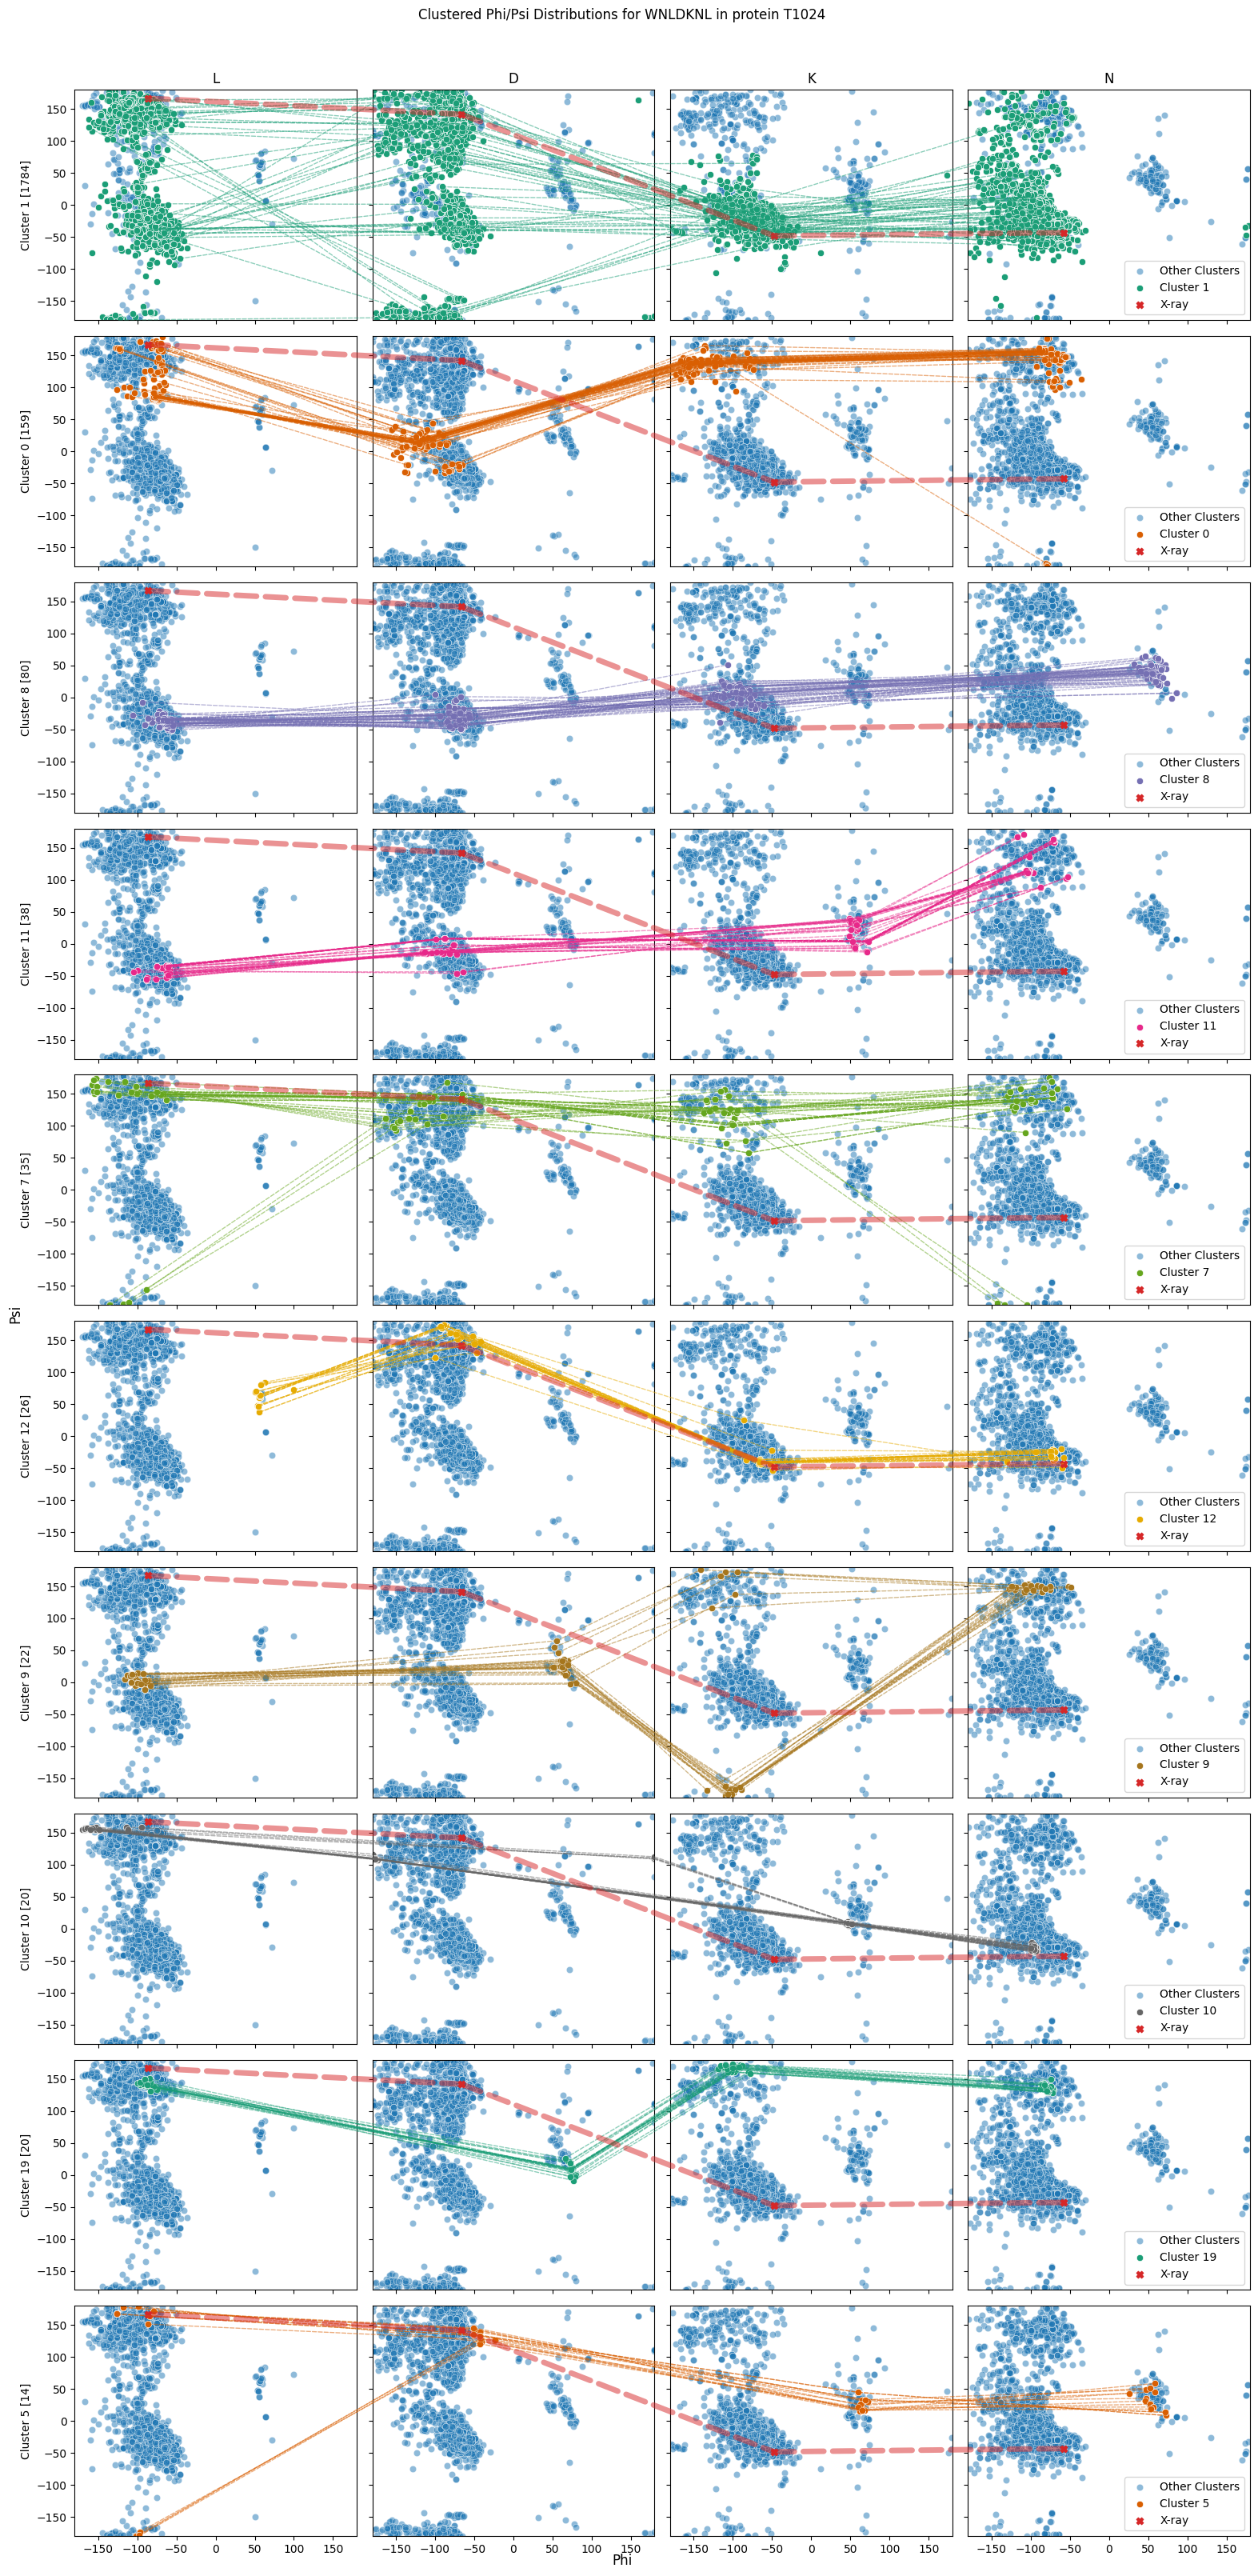

In [114]:
q = da.queries[0]
seq_ctxt = da.seqs_for_window[0]
phi_psi_dist = get_phi_psi_dist(q, seq_ctxt)
xrays, xray_point = get_xrays(da, q, seq_ctxt)

# max_sil_avg = -1
# for k in range(2, min(phi_psi_dist.shape[0], 2**q.winsize)):
#     kmeans = KMeans(n_clusters=k).fit(phi_psi_dist.values)
#     sil_avg = silhouette_score(phi_psi_dist.values, kmeans.labels_)
#     if sil_avg > max_sil_avg:
#         max_sil_avg = sil_avg
#         phi_psi_dist['cluster'] = kmeans.labels_
#         chosen_centroids = kmeans.cluster_centers_
#         n_clusters = k

# phi_psi_dist['cluster'] = DBSCAN(eps=75, min_samples=5).fit(phi_psi_dist.values).labels_
# n_clusters = len(phi_psi_dist.cluster.unique())
# print(n_clusters, phi_psi_dist.cluster.value_counts())

assign_clusters(phi_psi_dist)
print(n_clusters, phi_psi_dist.cluster.value_counts())
sil_score = silhouette_score(phi_psi_dist[phi_psi_dist.cluster != -1].iloc[:,:-1], phi_psi_dist[phi_psi_dist.cluster != -1].cluster)
print(sil_score)
xray_sil = xray_sil_score(phi_psi_dist, xray_point)
print(xray_sil)

clusters = phi_psi_dist[phi_psi_dist.cluster != -1].groupby('cluster').count().sort_values('phi_0', ascending=False).index.values

value_counts = phi_psi_dist.cluster.value_counts()
clusters_plot = value_counts[value_counts > 15].index.values
clusters_plot = clusters[:10]

# cluster_aves = phi_psi_dist.groupby('cluster').mean().loc[clusters_plot]

colors = sns.color_palette('Dark2', n_clusters)
fig, axes = plt.subplots(len(clusters_plot), q.winsize, figsize=(16, 32), sharey=True, sharex=True)
for i,axrow in enumerate(axes):
    for j, ax in enumerate(axrow):
        cluster_dist = phi_psi_dist[phi_psi_dist.cluster == clusters_plot[i]]

        sns.scatterplot(data=phi_psi_dist[phi_psi_dist.cluster != clusters_plot[i]], x=f'phi_{j}', y=f'psi_{j}', ax=ax, label='Other Clusters', color='tab:blue', alpha=0.5)
        sns.scatterplot(data=cluster_dist, x=f'phi_{j}', y=f'psi_{j}', ax=ax, label=f'Cluster {clusters_plot[i]}', color=colors[i])
        ax.scatter(xrays.phi.iloc[j], xrays.psi.iloc[j], color='tab:red', marker='X', label='X-ray', zorder=1000)
        # ax.scatter(cluster_aves.loc[clusters_plot[i]].values.reshape(2,-1)[0,j], cluster_aves.loc[clusters_plot[i]].values.reshape(2,-1)[1,j], color='tab:green', marker='X', label='Cluster Centroid', zorder=1000)

        def add_conn(xyA, xyB, color, lw, **kwargs):
            con = ConnectionPatch(
                xyA=xyA, 
                xyB=xyB, 
                coordsA="data", coordsB="data", 
                axesA=axrow[j], axesB=axrow[j+1], 
                color=color, lw=lw, linestyle='--', alpha=0.5, **kwargs
            )
            fig.add_artist(con)
        if j < q.winsize - 1:
            # TODO draw lines for 50 points closest to centroid
            for k, row in cluster_dist.sample(min(cluster_dist.shape[0], 50)).iterrows():
                add_conn((row[f'phi_{j}'], row[f'psi_{j}']), (row[f'phi_{j+1}'], row[f'psi_{j+1}']), colors[i], 1)
            add_conn((xrays.phi.iloc[j], xrays.psi.iloc[j]), (xrays.phi.iloc[j+1], xrays.psi.iloc[j+1]), 'tab:red', 5, zorder=100)

        ax.set_xlim(-180, 180)
        ax.set_ylim(-180, 180)
        ax.set_xlabel('')
        if j == q.winsize - 1:
            ax.legend()
        else:
            ax.legend().remove()
        if i == 0:
            ax.set_title(xrays.iloc[j].res)
        if j == 0:
            ax.set_ylabel(f'Cluster {clusters_plot[i]} [{cluster_dist.shape[0]}]')
fig.supxlabel('Phi')
fig.supylabel('Psi')
fig.suptitle(f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}', y=1.01)
plt.tight_layout()